In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1, 0)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(1, -1//2)
# general_lattice = ReciprocalLattice(abs(G2/G1), cos(θ)), use exact value to avoid uncertainty on Brillouin Zone boundary.

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(energies=energies, vectors=vectors; title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(ss_k1)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        if isassigned(energies,i)
            for e in energies[i]
                scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
            end
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x+0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
end

plot_entanglement_spectrum (generic function with 1 method)

In [31]:
# Define 3×4 k-mesh (Nk=13) for 1/3 + 1/3 filling
k_list = [0 1 2 3 4 5 0 1 2 3 4 5;
          0 0 0 0 0 0 1 1 1 1 1 1]

# System parameters
Nk = 12         # Total number of k-points
Gk = (6, 2)     # Grid dimensions (G1_direction, G2_direction)

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [2]:
# Define 3×4 k-mesh (Nk=13) for 1/3 + 1/3 filling
k_list = [0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3]

# System parameters
Nk = 12         # Total number of k-points
Gk = (3, 4)     # Grid dimensions (G1_direction, G2_direction)

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [3]:
# Set up one-body Hamiltonian matrix for inter-layer tunneling
ΔE = 0.0 * LLT.W0                # Energy difference between the two layers

# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, No tunneling
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(ReciprocalLattice(4//3, -1//2),
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [24]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 2.0                   # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:6; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:6; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
sys_int.V_intra = [0.0; 0.8; 0.0; 0.0]          # Intralayer Haldane pseudo-potential in unit of W0
sys_int.V_inter = [0.0; 0.0; 0.0; 0.0]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
# sys_int.V_intra = copy(intra_PP)
# sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 1                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.6326473915475541, 0.7473513096250322, 0.52670982841867, 0.4168315354285451, 0.3484803526664003, 0.30088572250719675, 0.26539345713301177]
inter_PP = [0.6204292660918972, 0.48449255713908407, 0.39848869807091536, 0.33925378440616344, 0.29584034949628485, 0.2625210735936332, 0.23603971504532437]


In [25]:
# number of electrons in each layer
Ne1 = 4
Ne2 = 0

0

In [26]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2, lf, li; 
        para = para, form_factor = true)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2], lf = 1:2, li=1:2
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        for lf = 1:2, li = 1:2
            structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] = 
                ED_bracket_threaded(myvec, 
                    densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], 
                    densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec
                )
            if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0 && lf==li
                structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] -= 
                    ED_bracket_threaded(myvec, densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], myvec) * 
                    ED_bracket_threaded(myvec, densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec)
            end
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [27]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = ED_momentum_subspaces(para, (Ne1, Ne2));
display(length.(subspaces))

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatterList_onebody(para);
scat_list2 = ED_sortedScatterList_twobody(para);

# construct the Hamiltonian operator
hmlt = MBOperator(scat_list2, scat_list1; upper_hermitian = true)

12-element Vector{Int64}:
 42
 40
 43
 40
 42
 40
 43
 40
 42
 40
 43
 40

Many Body Operator (upper_hermitian=true) :
	Vector{MomentumEDCore.Scatter{2}} with 432 scattering terms


In [28]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2, scat_list1;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 42, momentum 0, 0
  0.000449 seconds (237 allocations: 118.835 KiB)


┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED c:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:109


  0.115117 seconds (125.79 k allocations: 6.330 MiB, 95.76% compilation time)
Processing subspace #2 with size 40, momentum 0, 1
  0.001236 seconds (285 allocations: 109.359 KiB)
  0.000462 seconds (29 allocations: 108.166 KiB)
Processing subspace #3 with size 43, momentum 0, 2
  0.000508 seconds (281 allocations: 158.079 KiB)
  0.000387 seconds (29 allocations: 122.400 KiB)
Processing subspace #4 with size 40, momentum 0, 3
  0.001124 seconds (257 allocations: 124.614 KiB)
  0.000469 seconds (29 allocations: 108.104 KiB)
Processing subspace #5 with size 42, momentum 1, 0
  0.001277 seconds (292 allocations: 131.786 KiB)
  0.000559 seconds (29 allocations: 117.510 KiB)
Processing subspace #6 with size 40, momentum 1, 1
  0.001422 seconds (277 allocations: 120.201 KiB)
  0.000499 seconds (29 allocations: 108.104 KiB)
Processing subspace #7 with size 43, momentum 1, 2
  0.001207 seconds (267 allocations: 123.944 KiB)
  0.000406 seconds (29 allocations: 122.322 KiB)
Processing subspace #8

┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED c:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:109
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED c:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:109
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED c:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:109
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED c:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:109
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED c:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:109
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED c:\Users\zoubo\Documents\Julia\MomentumED.jl\Momentu

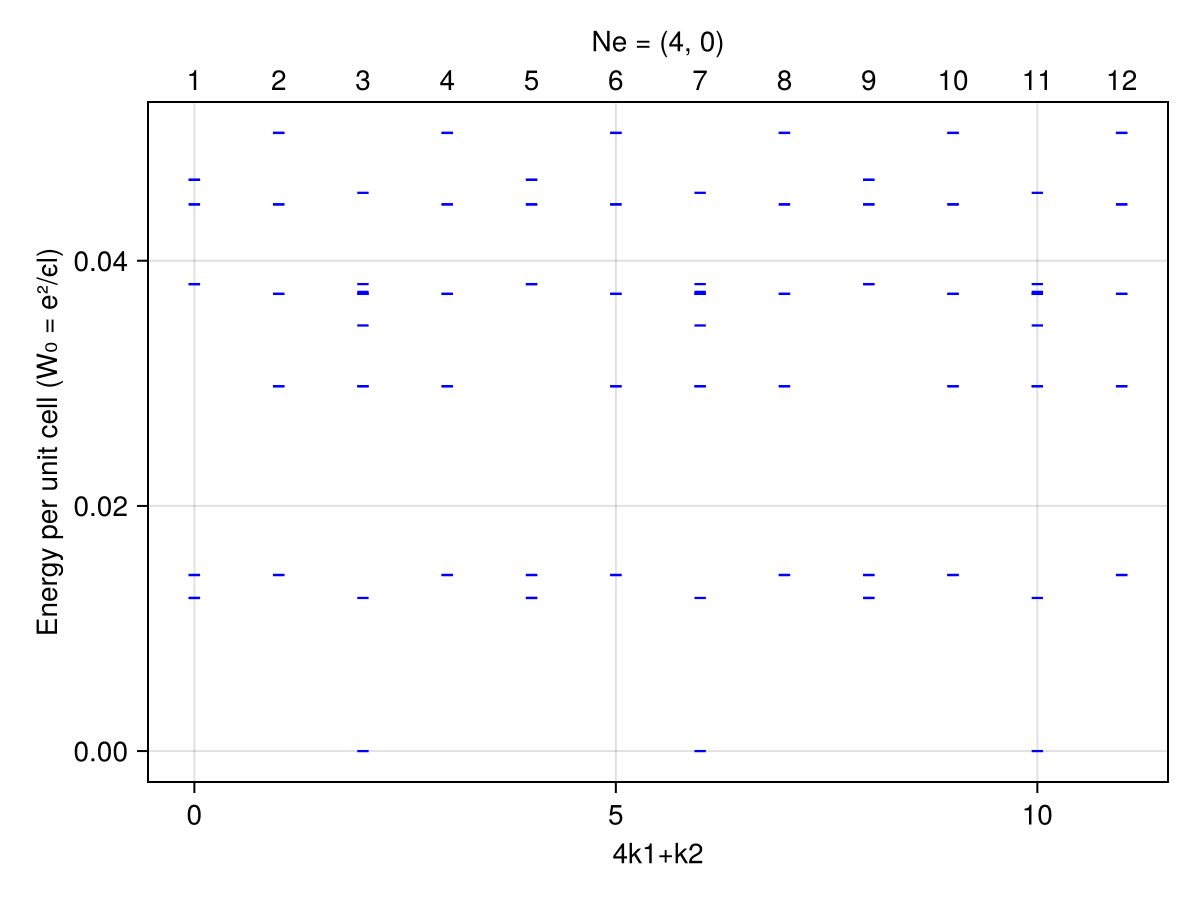

CairoMakie.Screen{IMAGE}


In [29]:
plot_ed_spectrum(title="Ne = ($Ne1, $Ne2)")

In [30]:
sn = 3 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  2


10-element Vector{Float64}:
 -1.4802973661668753e-16
  0.012490289685505362
  0.02976264393553656
  0.02976264393553678
  0.0347178675543835
  0.037294618285470656
  0.03729461828547081
  0.037459559605339976
  0.038090778831790455
  0.045537686431271436

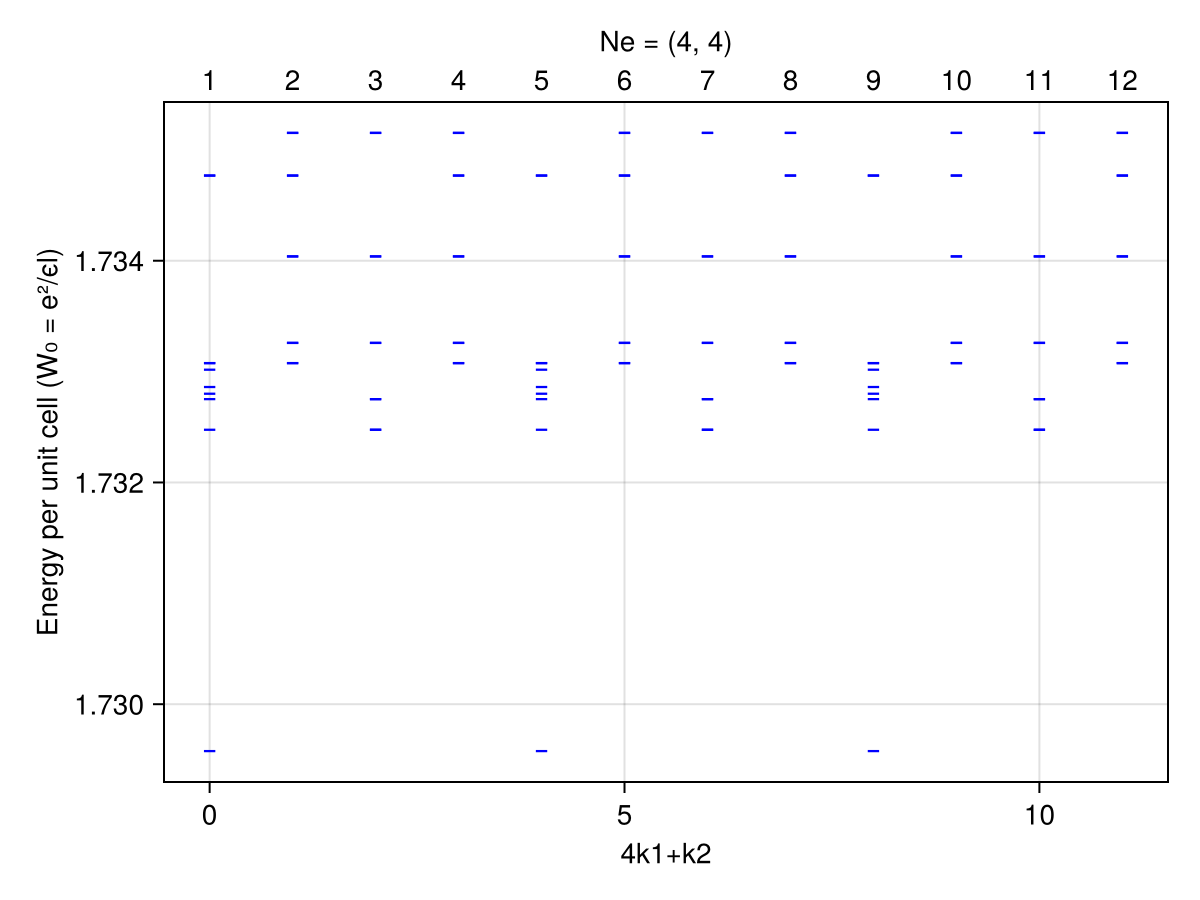

CairoMakie.Screen{IMAGE}


In [9]:
plot_ed_spectrum(title="Ne = ($Ne1, $Ne2)")

In [10]:
sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 1.729577307120443
 1.7324754298431966
 1.7327516385801678
 1.732800417668934
 1.7328610349636693
 1.7330171024769128
 1.733076558954281
 1.7330765589542831
 1.7347681701977986
 1.7347681701978013

In [14]:
sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 1.7281011979564225
 1.731265969118299
 1.7316105719534172
 1.7316105719534176
 1.7318567877388427
 1.7321680789655474
 1.732484436834973
 1.7330299412758128
 1.7331478751262805
 1.7336070799916516

structure factor

In [26]:
@time str_fac = structure_factor_expectation(vectors[1][1]);
@show maximum(abs.(imag.(str_fac)))
@show extrema(real.(str_fac))
@show str_fac[index_shift..., 1,2]
@show str_fac[index_shift..., 2,1]

  4.281243 seconds (81.22 k allocations: 5.214 MiB, 0.85% compilation time)
maximum(abs.(imag.(str_fac))) = 3.469446951953614e-18
extrema(real.(str_fac)) = (7.401486830834377e-15, 0.3282378604653125)
str_fac[index_shift..., 1, 2] = 0.10447601048474474 + 0.0im
str_fac[index_shift..., 2, 1] = 0.10447601048474457 + 0.0im


0.10447601048474457 + 0.0im

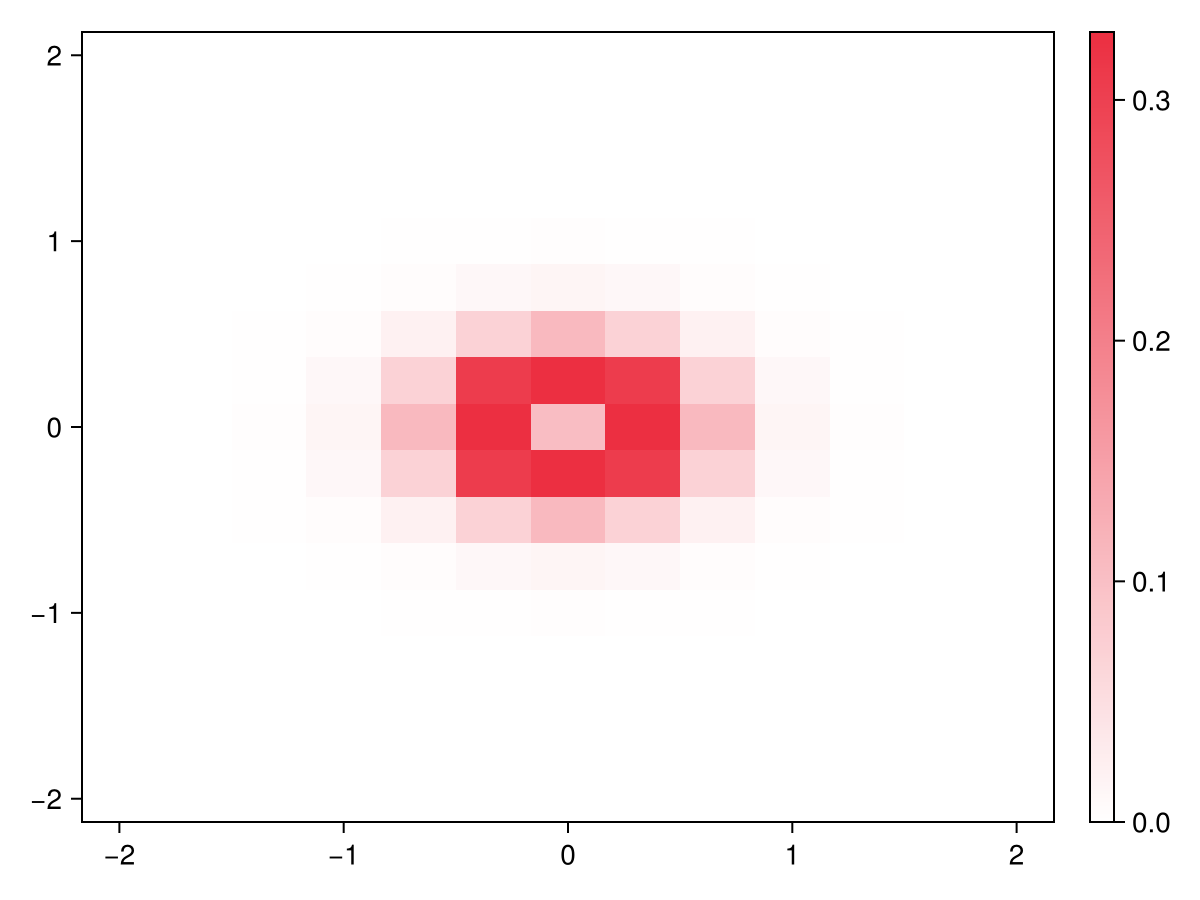

CairoMakie.Screen{IMAGE}


In [28]:
let structure_factor = str_fac, layer = (2,1)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end